In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import requests
import os
import seaborn as sns

In [3]:
DATA_PATH = 'data/'

In [68]:
NYC_FILENAME = DATA_PATH + 'NYPD Shooting Incident Data (Historic).zip'

In [5]:
NYC_URL = "https://data.cityofnewyork.us/api/geospatial/833y-fsy8?date=20231228&accessType=DOWNLOAD&method=export&format=Shapefile"

In [76]:
NYC_PREPARED_DATA_PATH = DATA_PATH + 'NYPD_Shooting_Incident_Data_PREPARE.csv'

In [6]:
IS_DOWNLOAD_DATASETS = True

# NEW YORK CITY SHOOTING INCIDENTS

# Download New York City Shooting Incident Data file locally or copy directly from link

In [7]:
if IS_DOWNLOAD_DATASETS:
    if not os.path.isfile(NYC_FILENAME):
        response = requests.get(NYC_URL)
        if response.status_code == 200:
            with open(NYC_FILENAME, 'wb') as file:
                file.write(response.content)
            print(f'File {NYC_FILENAME} has been successfully downloaded and saved.')
        else:
            print(f'Unable to download the file. HTTP response code: {response.status_code}')
    else:
        print(f'File {NYC_FILENAME} already exists on the disk.')
    nyc_df = gpd.read_file(NYC_FILENAME)
else:
    nyc_df = gpd.read_file(NYC_URL)
    print(f'Data has been copied from the link {NYC_URL}')

File data/NYPD Shooting Incident Data (Historic).zip already exists on the disk.


# Print shooting locations

In [8]:
nyc_df[:-10]

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry
0,228798151,2021-05-27,00:00:00.000,21:30:00,QUEENS,None,105.0,0.0,None,None,...,None,None,18-24,M,BLACK,1058925,180924,40.662965,-73.730839,POINT (-73.73084 40.66296)
1,137471050,2014-06-27,00:00:00.000,17:40:00,BRONX,None,40.0,0.0,None,None,...,None,None,18-24,M,BLACK,1005028.000000000000000,234516.000000000000000,40.810352,-73.924942,POINT (-73.92494 40.81035)
2,147998800,2015-11-21,00:00:00.000,03:56:00,QUEENS,None,108.0,0.0,None,None,...,None,None,25-44,M,WHITE,1007667.937500000000000,209836.531250000000000,40.742607,-73.915492,POINT (-73.91549 40.74261)
3,146837977,2015-10-09,00:00:00.000,18:30:00,BRONX,None,44.0,0.0,None,None,...,None,None,<18,M,WHITE HISPANIC,1006537.375000000000000,244511.140625000000000,40.837782,-73.919457,POINT (-73.91946 40.83778)
4,58921844,2009-02-19,00:00:00.000,22:58:00,BRONX,None,47.0,0.0,None,None,...,M,BLACK,45-64,M,BLACK,1024921.812500000000000,262189.406250000000000,40.886238,-73.852910,POINT (-73.85291 40.88624)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27297,247460145,2022-07-02,00:00:00.000,03:43:00,BROOKLYN,OUTSIDE,71.0,0.0,OTHER,HOSPITAL,...,(null),(null),25-44,F,WHITE HISPANIC,999439,178174,40.655711,-73.945257,POINT (-73.94526 40.65571)
27298,243566419,2022-04-12,00:00:00.000,20:40:00,BRONX,OUTSIDE,44.0,0.0,STREET,(null),...,(null),(null),18-24,F,BLACK,1007175,242911,40.833381,-73.917153,POINT (-73.91715 40.83338)
27299,239930944,2022-01-31,00:00:00.000,10:16:00,BROOKLYN,OUTSIDE,71.0,0.0,DWELLING,MULTI DWELL - APT BUILD,...,M,BLACK,45-64,M,BLACK,999955,181228,40.664092,-73.943389,POINT (-73.94339 40.66409)
27300,245666455,2022-05-25,00:00:00.000,19:14:00,BROOKLYN,INSIDE,75.0,0.0,DWELLING,PVT HOUSE,...,(null),(null),18-24,M,BLACK,1018979,182044,40.666280,-73.874814,POINT (-73.87481 40.66628)


In [9]:
nyc_df.shape

(27312, 22)

Text(0.5, 1.0, 'Strzelaniny w Nowym Jorku w latach 2006-2022')

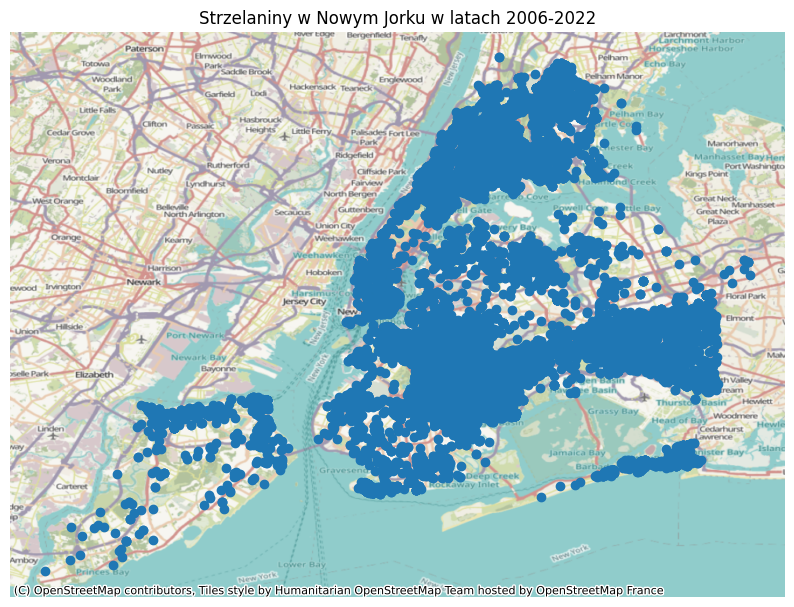

In [10]:
ax = nyc_df.plot(figsize=(10,10))
ctx.add_basemap(ax, crs=nyc_df.crs.to_string())
ax.set_axis_off()
plt.title("Strzelaniny w Nowym Jorku w latach 2006-2022")
# plt.show()

## Clean data

### Detection outliers

In [11]:
nyc_df[(nyc_df['latitude'] == 0) | (nyc_df['longitude'] == 0)]

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry


In [13]:
nyc_df[(nyc_df['latitude'].isnull()) | (nyc_df['longitude'].isnull())]

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry
1406,250584475,2022-09-03,00:00:00.000,22:45:00,BROOKLYN,OUTSIDE,90.0,0.0,STREET,(null),...,(null),(null),18-24,F,WHITE HISPANIC,998002,196692,NaN,NaN,None
25597,259091227,2022-12-19,00:00:00.000,23:23:00,BROOKLYN,OUTSIDE,60.0,0.0,STREET,(null),...,M,BLACK,25-44,M,BLACK,990784,149362,NaN,NaN,None
25598,251253188,2022-09-18,00:00:00.000,03:40:00,MANHATTAN,OUTSIDE,34.0,0.0,STREET,(null),...,(null),(null),18-24,M,BLACK HISPANIC,1002173,249401,NaN,NaN,None
25832,254053457,2022-11-13,00:00:00.000,01:00:00,QUEENS,OUTSIDE,110.0,0.0,PLAYGROUND,(null),...,M,WHITE HISPANIC,25-44,M,WHITE HISPANIC,1019164,210169,NaN,NaN,None
25938,252281471,2022-10-09,00:00:00.000,19:15:00,BROOKLYN,OUTSIDE,61.0,0.0,HOUSING,MULTI DWELL - PUBLIC HOUS,...,M,WHITE HISPANIC,25-44,M,BLACK,995122,155693,NaN,NaN,None
26273,251690448,2022-09-27,00:00:00.000,23:30:00,MANHATTAN,OUTSIDE,28.0,0.0,STREET,(null),...,M,BLACK,18-24,M,BLACK,997407,233806,NaN,NaN,None
26741,251690448,2022-09-27,00:00:00.000,23:30:00,MANHATTAN,OUTSIDE,28.0,0.0,STREET,(null),...,M,BLACK,25-44,M,BLACK,997407,233806,NaN,NaN,None
26814,255042633,2022-12-03,00:00:00.000,10:21:00,MANHATTAN,OUTSIDE,33.0,0.0,STREET,(null),...,(null),(null),18-24,M,BLACK HISPANIC,1001891,245600,NaN,NaN,None
26875,250460651,2022-09-01,00:00:00.000,01:15:00,QUEENS,OUTSIDE,103.0,0.0,OTHER,(null),...,(null),(null),18-24,M,BLACK,1041717,197008,NaN,NaN,None
27205,250340401,2022-08-30,00:00:00.000,00:10:00,BROOKLYN,OUTSIDE,84.0,0.0,STREET,(null),...,(null),(null),25-44,F,BLACK,988902,192641,NaN,NaN,None


In [14]:
print("Empty values in the column 'Longitude':", nyc_df['longitude'].isnull().sum())
print("Empty values in the column 'Latitude':", nyc_df['latitude'].isnull().sum())
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude'])

Empty values in the column 'Longitude': 10
Empty values in the column 'Latitude': 10


In [15]:
print("Empty values in the column 'Longitude':", nyc_df['longitude'].isnull().sum())
print("Empty values in the column 'Latitude':", nyc_df['latitude'].isnull().sum())

Empty values in the column 'Longitude': 0
Empty values in the column 'Latitude': 0


In [56]:
nyc_df['vic_age_gr'].unique()

array(['18-24', '25-44', '<18', '45-64', '65+', 'UNKNOWN', '1022'],
      dtype=object)

In [60]:
nyc_df['vic_race'].unique()

array(['BLACK', 'WHITE', 'WHITE HISPANIC', 'BLACK HISPANIC',
       'ASIAN / PACIFIC ISLANDER', 'UNKNOWN',
       'AMERICAN INDIAN/ALASKAN NATIVE'], dtype=object)

In [59]:
nyc_df['perp_race'].unique()

array([None, 'BLACK', 'UNKNOWN', 'BLACK HISPANIC',
       'ASIAN / PACIFIC ISLANDER', 'WHITE HISPANIC', 'WHITE',
       'AMERICAN INDIAN/ALASKAN NATIVE', '(null)'], dtype=object)

In [61]:
nyc_df['perp_age_g'].unique()

array([None, '25-44', 'UNKNOWN', '18-24', '45-64', '<18', '65+', '940',
       '224', '1020', '(null)'], dtype=object)

### Delete outliers

In [62]:
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude'])
condition = (nyc_df['vic_age_gr'] == '1022') | \
            (nyc_df['perp_age_g'] == '1020') | \
            (nyc_df['perp_age_g'] == '224') | \
            (nyc_df['perp_age_g'] == '940')

nyc_df = nyc_df[~condition]

In [64]:
nyc_df[nyc_df['vic_age_gr'] == '1022']

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry,year,month


In [65]:
nyc_df.shape

(27298, 24)

## Analysis data

In [18]:
print(f"Descriptions: {nyc_df.crs}\n"); print(f"Columns: {nyc_df.columns}\n"); print(f"Shape: {nyc_df.shape}");  print(f"Info: {nyc_df.info()}")

Descriptions: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]

Columns: Index(['incident_k', 'date_occur', 'time_occur', 'occur_time', 'boro',
       'loc_of_occ', 'precinct', 'jurisdicti', 'loc_classf', 'location_d',
       'statistica', 'perp_age_g', 'perp_sex', 'perp_race', 'vic_age_gr',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geometry'],
      dtype='object')

Shape: (27302, 22)
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27302 entries, 0 to 27311
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   incident_k  27302 non-null  object  
 1   date_occur  27302 non-null  object  
 2   time_occur  27302 non-null  object  
 3   occur_time  27302 non-null  object  
 4   boro        27302 non-null  object  
 5   loc_of_occ  1706 non-nu

### Shooting incidents trends

In [27]:
nyc_df['date_occur'] = pd.to_datetime(nyc_df['date_occur'])
nyc_df['year'] = nyc_df['date_occur'].dt.year
nyc_df['month'] = nyc_df['date_occur'].dt.month

# Calculate average events per year
avg_events_per_year = nyc_df.groupby('year').size().mean()
print(f"Average shooting incidents per year: {avg_events_per_year}")

Average shooting incidents per year: 1606.0


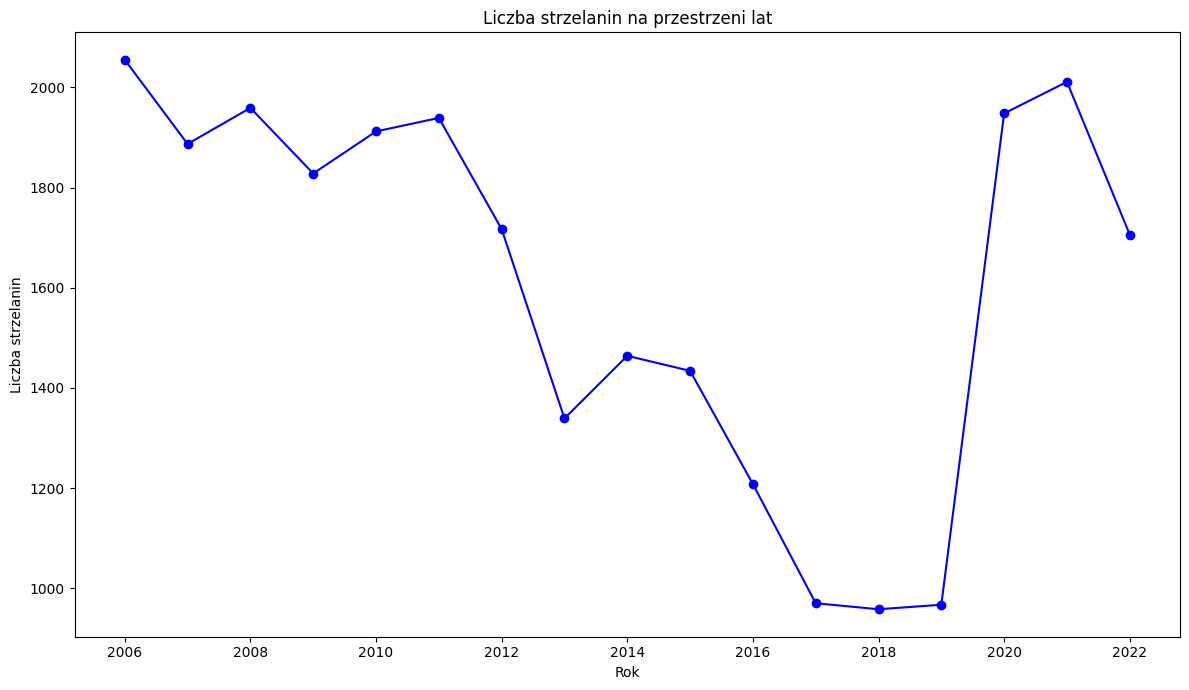

In [28]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))

# Yearly trend of incidents
nyc_df.groupby('year').size().plot(ax=axes, color='blue', marker='o', linestyle='-')
axes.set_title('Liczba strzelanin na przestrzeni lat')
axes.set_xlabel('Rok')
axes.set_ylabel('Liczba strzelanin')

plt.tight_layout()
plt.show()

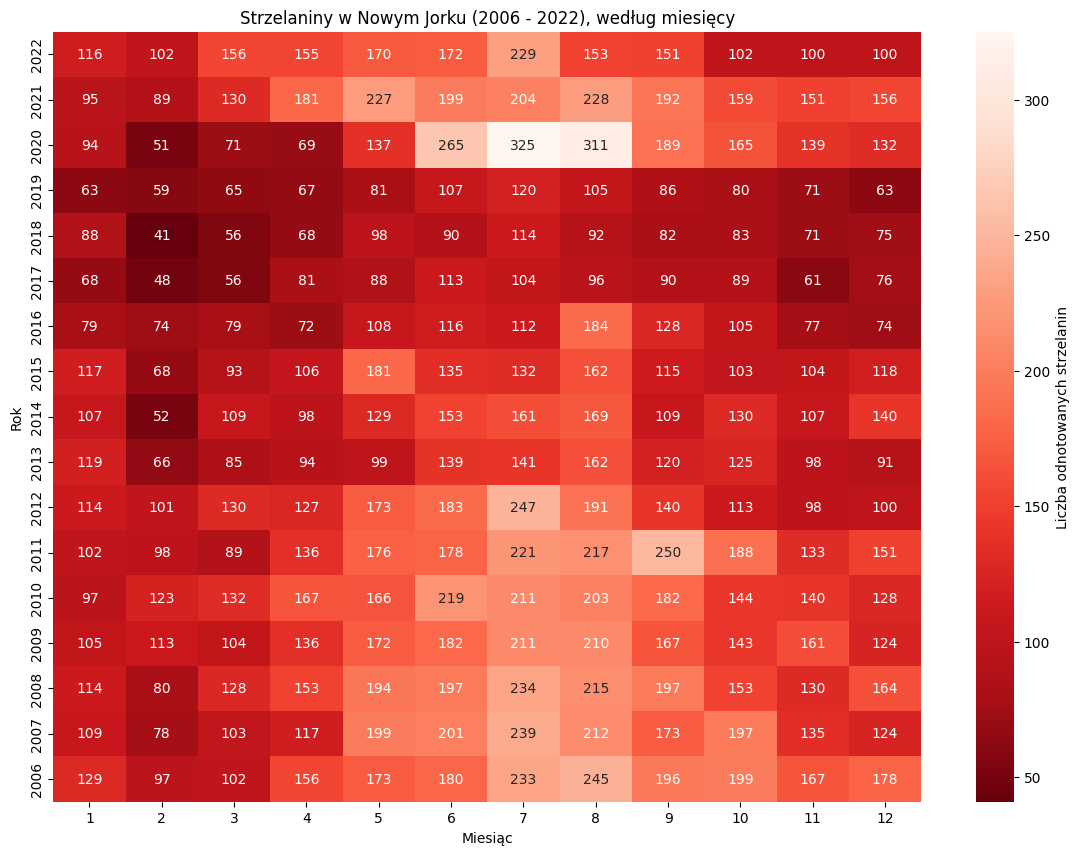

In [42]:
pivot_table = nyc_df.pivot_table(index='year', columns='month', aggfunc='size', fill_value=0)

pivot_table_reversed = pivot_table.iloc[::-1]
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_reversed, annot=True, fmt="d", cmap='Reds_r', cbar_kws={'label': 'Liczba odnotowanych strzelanin'})
plt.title('Strzelaniny w Nowym Jorku (2006 - 2022), według miesięcy')
plt.xlabel('Miesiąc')
plt.ylabel('Rok')
plt.show()

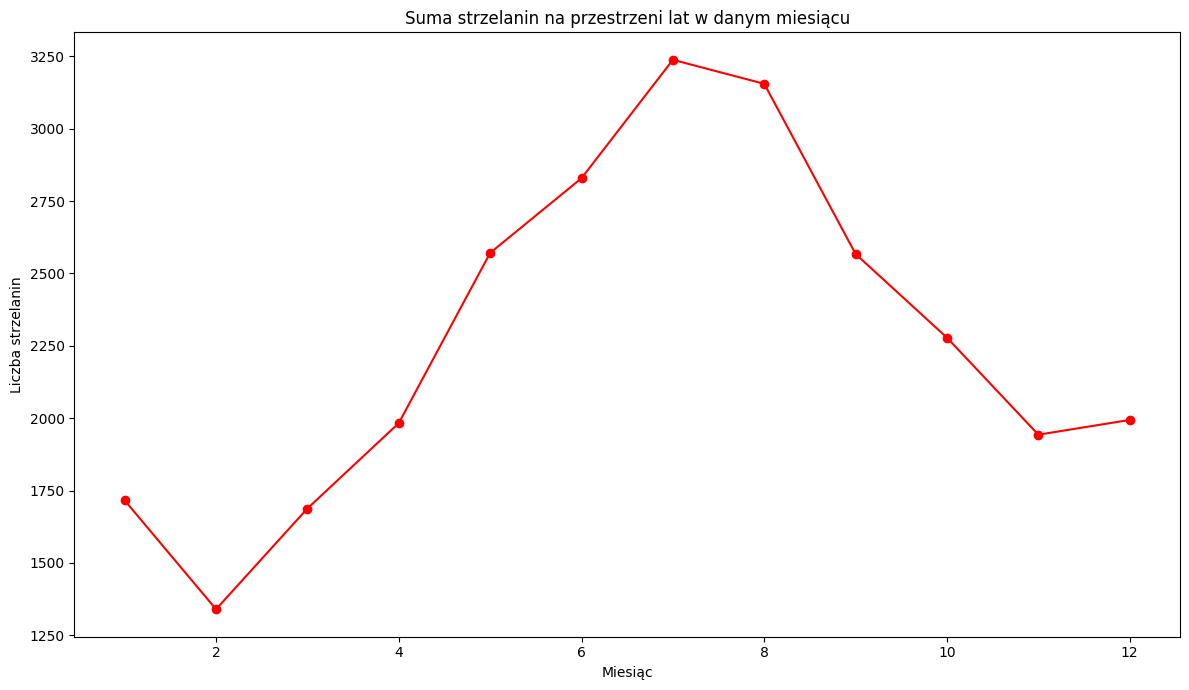

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))

# Monthly trend of incidents (average across all years)
nyc_df.groupby('month').size().plot(ax=axes, color='red', marker='o', linestyle='-')
axes.set_title('Suma strzelanin na przestrzeni lat w danym miesiącu')
axes.set_xlabel('Miesiąc')
axes.set_ylabel('Liczba strzelanin')

plt.tight_layout()
plt.show()

In [45]:
nyc_df.describe()

,date_occur,precinct,jurisdicti,latitude,longitude,year,month
count,27302,27302.000000,27300.000000,27302.000000,27302.000000,27302.000000,27302.000000
mean,2014-01-05 19:07:54.426782208,65.636290,0.327033,40.737892,-73.909051,2013.489378,6.824079
min,2006-01-01 00:00:00,1.000000,0.000000,40.511586,-74.249303,2006.000000,1.000000
25%,2009-07-18 00:00:00,44.000000,0.000000,40.668481,-73.943027,2009.000000,5.000000
50%,2013-04-27 00:00:00,68.000000,0.000000,40.700318,-73.915221,2013.000000,7.000000
75%,2018-10-08 18:00:00,81.000000,0.000000,40.824067,-73.882330,2018.000000,9.000000
max,2022-12-31 00:00:00,123.000000,2.000000,40.910818,-73.702046,2022.000000,12.000000
std,NaN,27.304504,0.737851,0.087525,0.066272,5.141450,3.128811


array([[<Axes: title={'center': 'date_occur'}>,
        <Axes: title={'center': 'precinct'}>,
        <Axes: title={'center': 'jurisdicti'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >, <Axes: >]],
      dtype=object)

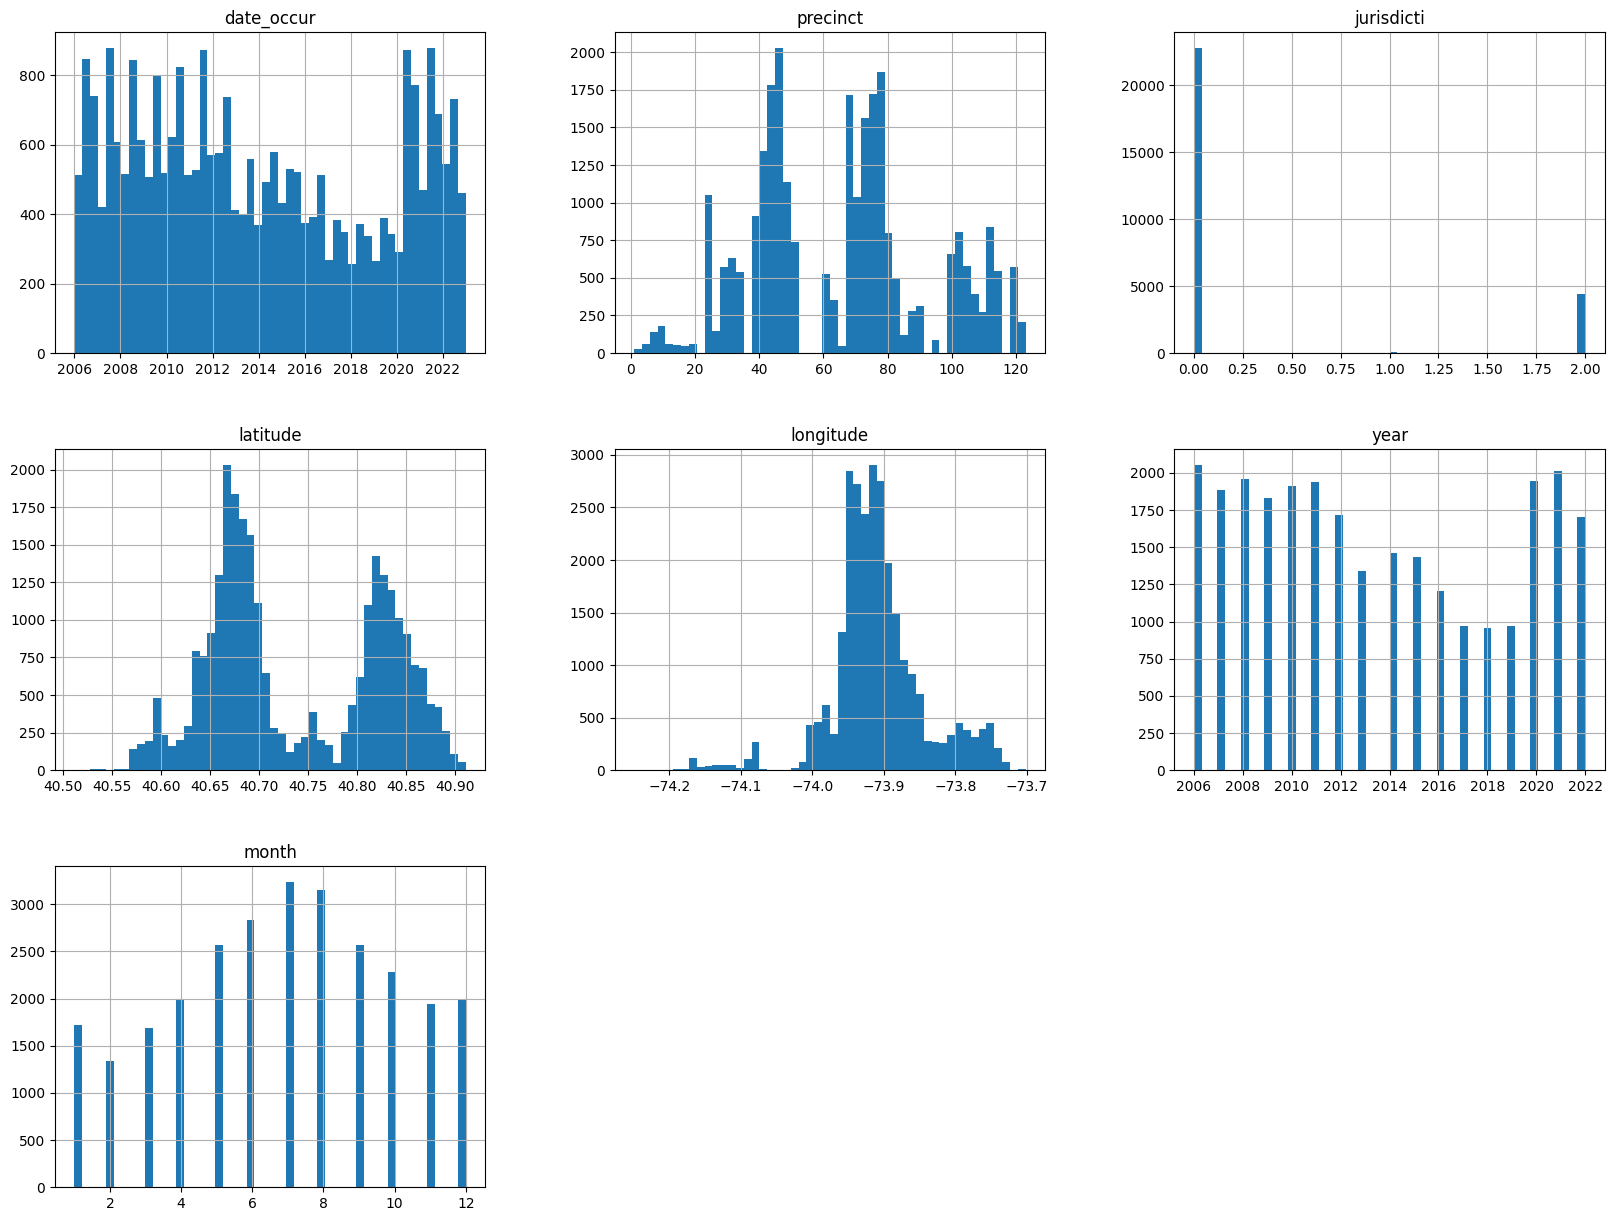

In [46]:
nyc_df.hist(bins=50,figsize=(20,15))

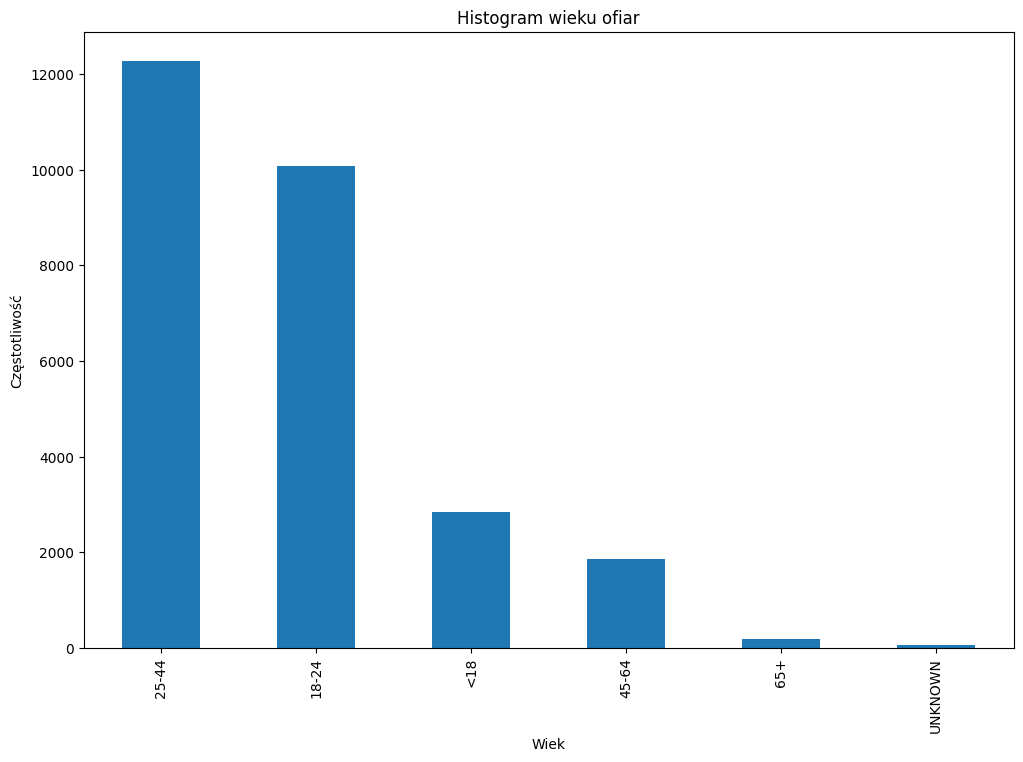

In [66]:
value_counts = nyc_df['vic_age_gr'].value_counts()

plt.figure(figsize=(12,8))
value_counts.plot(kind='bar')
plt.title('Histogram wieku ofiar')
plt.xlabel('Wiek')
plt.ylabel('Częstotliwość')
plt.show()

In [47]:
nyc_df.vic_sex.value_counts()

vic_sex
M    24678
F     2613
U       11
Name: count, dtype: int64

In [51]:
nyc_df.perp_sex.value_counts()

perp_sex
M         15434
U          1499
(null)      635
F           424
Name: count, dtype: int64

In [48]:
pd.get_dummies(nyc_df['vic_sex']).head()

,F,M,U
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False


## Saving the prepared data to a file

In [72]:
nyc_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27298 entries, 0 to 27311
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   incident_k  27298 non-null  object        
 1   date_occur  27298 non-null  datetime64[ns]
 2   time_occur  27298 non-null  object        
 3   occur_time  27298 non-null  object        
 4   boro        27298 non-null  object        
 5   loc_of_occ  1705 non-null   object        
 6   precinct    27298 non-null  float64       
 7   jurisdicti  27296 non-null  float64       
 8   loc_classf  1705 non-null   object        
 9   location_d  12321 non-null  object        
 10  statistica  27298 non-null  object        
 11  perp_age_g  17954 non-null  object        
 12  perp_sex    17988 non-null  object        
 13  perp_race   17988 non-null  object        
 14  vic_age_gr  27298 non-null  object        
 15  vic_sex     27298 non-null  object        
 16  vic_race    27298 n

In [73]:
nyc_df = nyc_df.drop(['year', 'month'], axis=1)

In [74]:
nyc_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 27298 entries, 0 to 27311
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   incident_k  27298 non-null  object        
 1   date_occur  27298 non-null  datetime64[ns]
 2   time_occur  27298 non-null  object        
 3   occur_time  27298 non-null  object        
 4   boro        27298 non-null  object        
 5   loc_of_occ  1705 non-null   object        
 6   precinct    27298 non-null  float64       
 7   jurisdicti  27296 non-null  float64       
 8   loc_classf  1705 non-null   object        
 9   location_d  12321 non-null  object        
 10  statistica  27298 non-null  object        
 11  perp_age_g  17954 non-null  object        
 12  perp_sex    17988 non-null  object        
 13  perp_race   17988 non-null  object        
 14  vic_age_gr  27298 non-null  object        
 15  vic_sex     27298 non-null  object        
 16  vic_race    27298 n

In [77]:
nyc_df.to_csv(NYC_PREPARED_DATA_PATH, index=False)